In [184]:
import sys
import importlib
import datetime

import numpy as np
import pandas as pd
import xarray as xr
import pvlib as pv
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import scipy.ndimage.filters as filters
from distributed import LocalCluster, Client
from skimage import filters as ski_filters
from skimage import feature as ski_feature

In [ ]:
%matplotlib inline

In [2]:
%matplotlib notebook

In [3]:
sys.path.append('/home/travis/python_code/letkf_forecasting/')
import letkf_forecasting as lf

In [4]:
import prepare_sat_data as prep
import random_functions as rf

In [5]:
sensor_data = pd.read_hdf('/home/travis/python_code/letkf_forecasting/data/sensor_data.h5')
sensor_CI = pd.read_hdf('/home/travis/python_code/letkf_forecasting/data/sensor_CI.h5')
sensor_loc = pd.read_hdf('/home/travis/python_code/letkf_forecasting/data/sensor_loc.h5')

In [ ]:
plt.figure()
sensor_CI[sensor_loc[sensor_loc.test==True].id].ix['2014-04-15 12:30' : '2014-04-15 13:30'].plot()

for i in sensor_loc[sensor_loc.test==False].id:
    plt.figure()
    plt.plot(sensor_data[sensor_data.id==i]['clearsky_profile'].ix['2014-04-15'])
    plt.plot(sensor_data[sensor_data.id==i]['ghi'].ix['2014-04-15'])

In [6]:
sensor_loc.sort_values(by='id', inplace=True)

In [7]:
cloudiness_14 = pd.read_hdf('./data/for_15/cloudiness_14.h5')
cloudiness_15 = pd.read_hdf('./data/for_15/cloudiness_15.h5')

corrected_cloudiness = (cloudiness_15 - cloudiness_14).clip(lower=0)
SUNY_coeff = np.array(np.array([2.36, -6.2, 6.22, -2.63, -0.58, 1]))
# cc_crop = corrected_cloudiness[flat_crop_indicies]
# cc_crop.columns = np.arange(flat_crop_indicies.size, dtype='int')

In [8]:
# csi_15 = pd.read_hdf('./data/for_15/csi_15.h5')
U_15 = pd.read_hdf('./data/for_15/U_fine.h5')
V_15 = pd.read_hdf('./data/for_15/V_fine.h5')
U_shape = np.load('./data/for_15/U_fine_shape.npy')
V_shape = np.load('./data/for_15/V_fine_shape.npy')

In [9]:
## filter winds
filter_len = 100*4
U_smooth = U_15.values.reshape(
    [U_15.shape[0], U_shape[0], U_shape[1]])
U_smooth = filters.uniform_filter(
    U_smooth, size=(0, filter_len, filter_len))
this_shape = U_smooth.shape
U_smooth = U_smooth.reshape(this_shape[0], this_shape[1]*this_shape[2])
U_smooth = pd.DataFrame(data=U_smooth, index=U_15.index)

V_smooth = V_15.values.reshape(
    [V_15.shape[0], V_shape[0], V_shape[1]])
V_smooth = filters.uniform_filter(
    V_smooth, size=(0, filter_len, filter_len))
this_shape = V_smooth.shape
V_smooth = V_smooth.reshape(this_shape[0], this_shape[1]*this_shape[2])
V_smooth = pd.DataFrame(data=V_smooth, index=V_15.index)

In [10]:
x_sat = np.load('./data/for_15/x_fine.npy')
y_sat = np.load('./data/for_15/y_fine.npy')
domain_shape = np.load('./data/for_15/fine_shape.npy')

In [11]:
x_range = x_sat.reshape(domain_shape)[0, :]
y_range = y_sat.reshape(domain_shape)[:, 0]

In [12]:
lon_sens = sensor_loc['lon'].values
lat_sens = sensor_loc['lat'].values

In [13]:
x_sens, y_sens = prep.sphere_to_lcc(lat_sens, lon_sens)
x_min = np.floor(x_sens.min())
x_max = np.ceil(x_sens.max())
y_min = np.floor(y_sens.min())
y_max = np.ceil(y_sens.max())
west_east_min = np.argmin(abs(x_min - x_range))
west_east_max = np.argmin(abs(x_max - x_range))
south_north_min = np.argmin(abs(y_min - y_range))
south_north_max = np.argmin(abs(y_max - y_range))

In [14]:
U_max = U_15.values.max() # know U is positive
V_max = abs(V_15.values.min()) # know V is negative

left = int(U_max*60*30/250) + 40
right = 40

up = int(V_max*60*30/250) + 40
down = 40

west_east_range = np.arange(west_east_min - left, west_east_max + right + 1, dtype='int')
west_east_range_stag = np.arange(west_east_min - left, west_east_max + right + 1 + 1, dtype='int')
south_north_range = np.arange(south_north_min - down, south_north_max + up + 1, dtype='int')
south_north_range_stag = np.arange(south_north_min - down, south_north_max + up + 1 + 1, dtype='int')
crop_shape = (south_north_range.size, west_east_range.size)
U_crop_shape = (south_north_range.size, west_east_range_stag.size)
V_crop_shape = (south_north_range_stag.size, west_east_range.size)
print('X length: ' + 
      str(west_east_range.size))
print('Y length: ' + 
      str(south_north_range.size))

X length: 478
Y length: 393


In [15]:
west_east_crop, south_north_crop = np.meshgrid(west_east_range, south_north_range)
crop_indicies_2d = np.array([south_north_crop.ravel(),
                             west_east_crop.ravel()])
flat_crop_indicies = np.ravel_multi_index(crop_indicies_2d,
                                          domain_shape)

In [16]:
west_east_crop_U, south_north_crop_U = np.meshgrid(west_east_range_stag, south_north_range)
crop_indicies_2d_U = np.array([south_north_crop_U.ravel(),
                               west_east_crop_U.ravel()])
flat_crop_indicies_U = np.ravel_multi_index(crop_indicies_2d_U,
                                            U_shape)

In [17]:
west_east_crop_V, south_north_crop_V = np.meshgrid(west_east_range, south_north_range_stag)
crop_indicies_2d_V = np.array([south_north_crop_V.ravel(),
                               west_east_crop_V.ravel()])
flat_crop_indicies_V = np.ravel_multi_index(crop_indicies_2d_V,
                                            V_shape)

In [18]:
x_crop = x_sat[flat_crop_indicies]
y_crop = y_sat[flat_crop_indicies]

In [19]:
x_crop_range = x_crop.reshape(crop_shape)[0, :]
y_crop_range = y_crop.reshape(crop_shape)[:, 0]

In [20]:
west_east_min = np.argmin(abs(x_min - x_crop_range))
west_east_max = np.argmin(abs(x_max - x_crop_range))
south_north_min = np.argmin(abs(y_min - y_crop_range))
south_north_max = np.argmin(abs(y_max - y_crop_range))
we_error_range = np.arange(west_east_min - 8, west_east_max + 9, dtype='int')
sn_error_range = np.arange(south_north_min - 8, south_north_max + 9, dtype='int')
error_domain_shape = (sn_error_range.size, we_error_range.size)
print('X length: ' + 
      str(we_error_range.size))
print('Y length: ' + 
      str(sn_error_range.size))

X length: 177
Y length: 241


In [21]:
west_east_error_crop, south_north_error_crop = np.meshgrid(
    we_error_range, sn_error_range)
crop_indicies_2d_error = np.array([south_north_error_crop.ravel(),
                             west_east_error_crop.ravel()])
flat_error_domain = np.ravel_multi_index(crop_indicies_2d_error,
                                         crop_shape)

In [22]:
cci_crop = corrected_cloudiness[flat_crop_indicies]
cci_crop.columns = np.arange(flat_crop_indicies.size, dtype='int')
csi_crop = pd.DataFrame(data=np.polyval(SUNY_coeff, cci_crop),
                        index=cci_crop.index)

In [23]:
U_crop = U_smooth[flat_crop_indicies_U]
U_crop.columns = np.arange(flat_crop_indicies_U.size, dtype='int')
V_crop = V_smooth[flat_crop_indicies_V]
V_crop.columns = np.arange(flat_crop_indicies_V.size, dtype='int')

In [24]:
U_const = pd.DataFrame(data=np.ones_like(U_crop),
                       index=U_crop.index)*22.9
V_const = pd.DataFrame(data=np.ones_like(V_crop),
                       index=V_crop.index)*-2

In [136]:
importlib.reload(rf)
Lx = 10 # 1
Ly = 10 # 1
tol = 0.001
e, v = rf.eig_2d_covariance(
    x=x_crop_range, y=y_crop_range,
    Lx=Lx, Ly=Ly, tol=tol)
print(e.size)

66


In [169]:
importlib.reload(rf)
Lx = 2.5 # 1
Ly = 2.5 # 1
tol = 0.001
e, v = rf.eig_2d_covariance(
    x=x_crop_range, y=y_crop_range,
    Lx=Lx, Ly=Ly, tol=tol)
print(e.size)

923


In [160]:
e = np.load('./data/rf_eigenvalues.npy')
v = np.load('./data/rf_eigenvectors.npy')
approx_var = np.load('./data/rf_approx_var.npy').item()

In [ ]:
%%timeit -n10
ens_size = 4
normal = np.random.randn(e.size, ens_size)
this = v.dot((np.sqrt(e[:, None])*normal))
this = this.reshape(y_crop_range.size,
                        x_crop_range.size,
                        ens_size)

In [170]:
ens_size = 40
normal = np.random.randn(e.size, ens_size)
sample = v.dot((np.sqrt(e[:, None])*normal))
sample = sample.reshape(y_crop_range.size,
                        x_crop_range.size,
                        ens_size)

/home/travis/miniconda3/envs/py35Solar/lib/python3.5/site-packages/matplotlib/pyplot.py:516: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


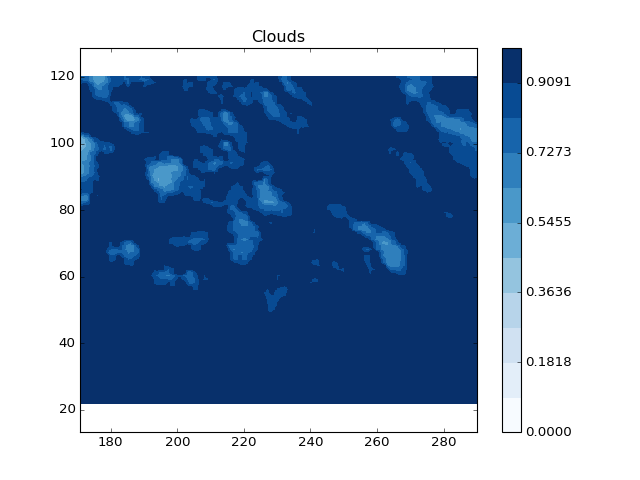

<IPython.core.display.Javascript object>


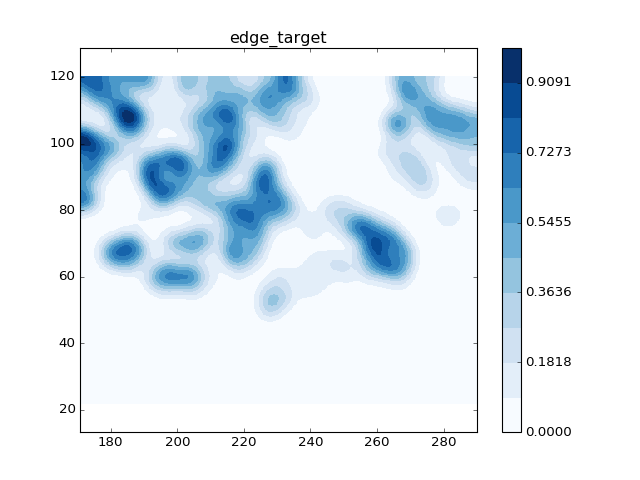

<IPython.core.display.Javascript object>


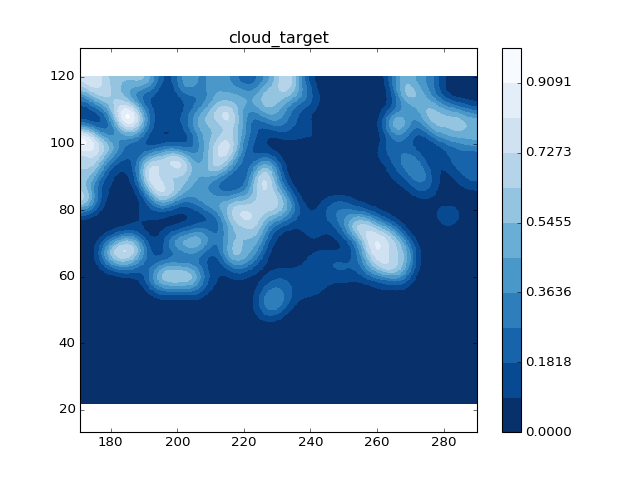

(22.0, 120.0)

In [189]:
sn_crop = slice(150, 300)
we_crop = slice(250, 400)
sn_crop = None
we_crop = None

plt_x_min = x_crop.reshape(crop_shape)[sn_crop, we_crop].min()
plt_x_max = x_crop.reshape(crop_shape)[sn_crop, we_crop].max()
plt_y_min = y_crop.reshape(crop_shape)[sn_crop, we_crop].min()
plt_y_max = y_crop.reshape(crop_shape)[sn_crop, we_crop].max()

date = '2014-04-15 12:30:00'
# for date in pd.date_range('2014-04-15 12:00:00', '2014-04-15 13:30:00', freq='15min'):
clouds = csi_crop.loc[date].values.reshape(crop_shape)
sobel = ski_filters.sobel(clouds)

vmin = 0
vmax = 1
nc = 12
bounds = np.linspace(vmin, vmax, nc)
norm = colors.BoundaryNorm(boundaries=bounds, ncolors=256)

plt.figure()
im = plt.pcolormesh(
    x_crop.reshape(crop_shape),
    y_crop.reshape(crop_shape),
    clouds,
    norm=norm,
    cmap='Blues')
plt.colorbar(im)
plt.title('Clouds')
plt.axis('equal')
plt.gca().set_xlim((plt_x_min, plt_x_max))
plt.gca().set_ylim((plt_y_min, plt_y_max))

# plt.figure()
# im = plt.pcolormesh(
#     x_crop.reshape(crop_shape),
#     y_crop.reshape(crop_shape),
#     sobel,
#     cmap='Blues')
# plt.colorbar(im)
# plt.title('Sobel')
# plt.axis('equal')
# plt.gca().set_xlim((plt_x_min, plt_x_max))
# plt.gca().set_ylim((plt_y_min, plt_y_max))

edge_target = sobel
edge_target = edge_target/edge_target.max()
edge_target[edge_target<.1] = 0
edge_target = filters.gaussian_filter(edge_target, sigma=10)
edge_target = edge_target/edge_target.max()


plt.figure()
im = plt.pcolormesh(
    x_crop.reshape(crop_shape),
    y_crop.reshape(crop_shape),
    edge_target,
    norm=norm,
    cmap='Blues')
plt.colorbar(im)
plt.title('edge_target')
plt.axis('equal')
plt.gca().set_xlim((plt_x_min, plt_x_max))
plt.gca().set_ylim((plt_y_min, plt_y_max))

cloud_target = 1 - clouds
cloud_target = (cloud_target/cloud_target.max()).clip(min=0, max=1)
cloud_target = np.maximum(cloud_target, edge_target*1)
cloud_target = cloud_target/cloud_target.max()
cloud_target = filters.gaussian_filter(cloud_target, sigma=5)

plt.figure()
im = plt.pcolormesh(
    x_crop.reshape(crop_shape),
    y_crop.reshape(crop_shape),
    cloud_target,
    norm=norm,
    cmap='Blues_r')
plt.colorbar(im)
plt.title('cloud_target')
plt.axis('equal')
plt.gca().set_xlim((plt_x_min, plt_x_max))
plt.gca().set_ylim((plt_y_min, plt_y_max))


# for n in range(5):
#     plt.figure()
#     im = plt.pcolormesh(
#         x_crop.reshape(crop_shape),
#         y_crop.reshape(crop_shape),
#         (clouds + (.*sample[:, :, n] + 0)*cloud_target).clip(min=0, max=1),
# #         cmap='Set1',
#         cmap='Blues',
#         norm=norm,)
#     plt.colorbar(im)
#     plt.title('CSI Preturbed')
#     plt.axis('equal')
#     plt.gca().set_xlim((plt_x_min, plt_x_max))
#     plt.gca().set_ylim((plt_y_min, plt_y_max))

In [ ]:
this_en = None
Tv = v[:, :this_en]*cloud_target.ravel()[:, None]
var = (Tv*e[None, :this_en]*Tv).sum(-1)
ave_sd = np.sqrt(var.mean())
print('Average sd: ' + str(ave_sd))

In [171]:
approx_var = (v*e[None, :]*v).sum(-1)
print(approx_var)
approx_var = approx_var.mean()
print(approx_var)

[ 0.64501467  0.69332815  0.73475556 ...,  0.73475556  0.69332815
  0.64501467]
0.948286524437


In [ ]:
plt.figure()
im = plt.pcolormesh(approx_var.reshape(crop_shape))
plt.colorbar(im)

In [172]:
pert_sigma = 0.12/3
pert_mean = 0.02/3

mean = 0 # -0.001
sd = 0.02 # 0.10 #0.015
cor_mean = mean/cloud_target.mean()
# cor_sd = sd/ave_sd
cor_sd = sd/np.sqrt((approx_var*(cloud_target**2).mean()))
# cor_sd = sd/approx_var.mean()
# cor_sd = sd/cloud_target.mean()

cloud_sample = (clouds[:, :, None] + (cor_sd*sample + cor_mean)*cloud_target[:, :, None])
this_mean = (cloud_sample.mean(axis=2) - clouds).mean()
this_sd = np.sqrt((cloud_sample.var(axis=2)).mean())
print('Mean: ' + str(this_mean))
print('Standard Deviation: ' + str(this_sd))

Mean: 0.000262349755298
Standard Deviation: 0.0197441821601


/home/travis/miniconda3/envs/py35Solar/lib/python3.5/site-packages/matplotlib/pyplot.py:516: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


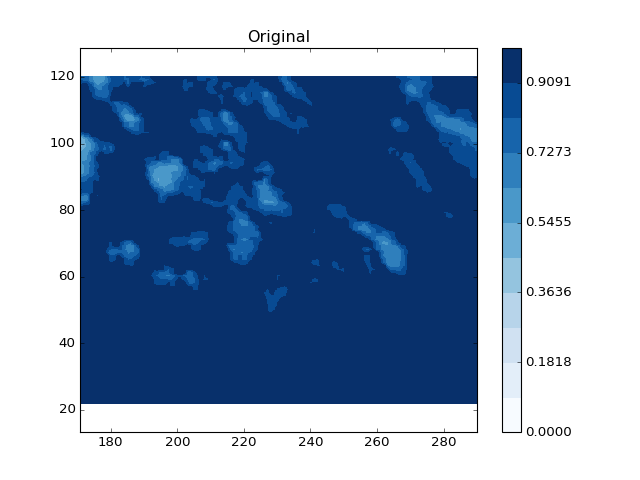

<IPython.core.display.Javascript object>


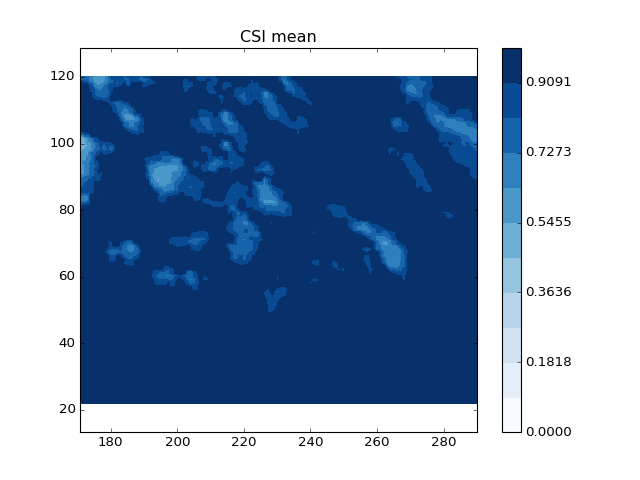

<IPython.core.display.Javascript object>


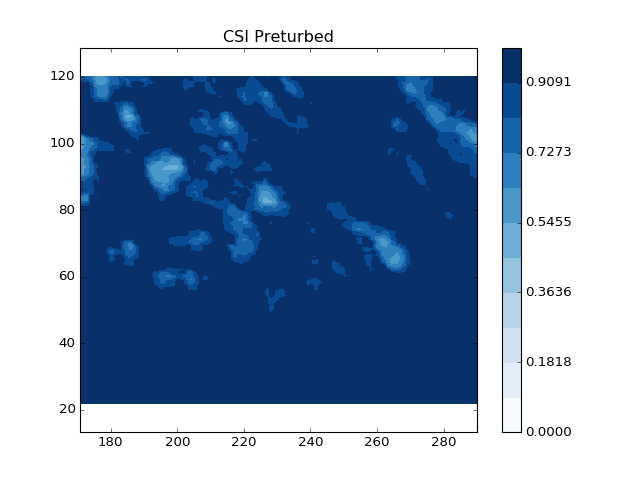

<IPython.core.display.Javascript object>


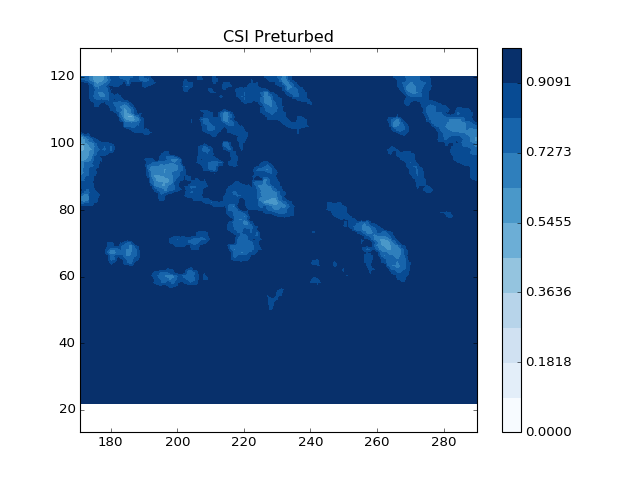

<IPython.core.display.Javascript object>


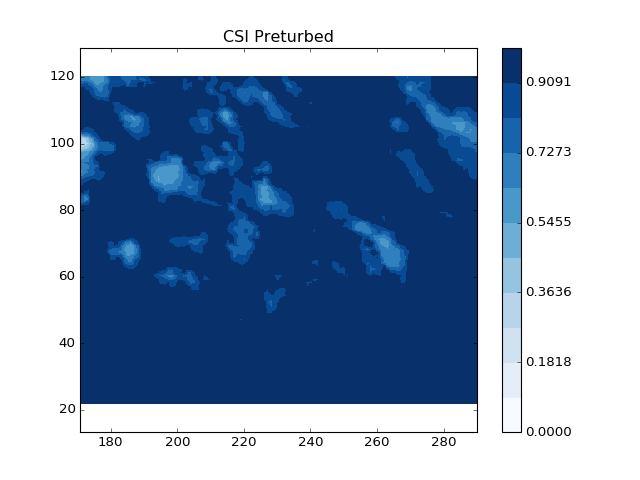

<IPython.core.display.Javascript object>


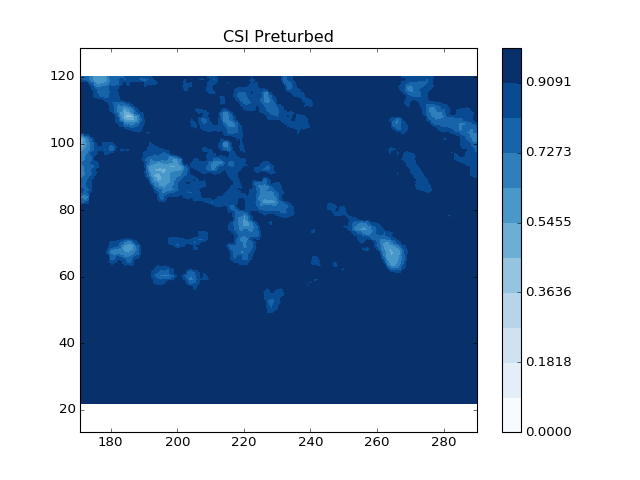

<IPython.core.display.Javascript object>


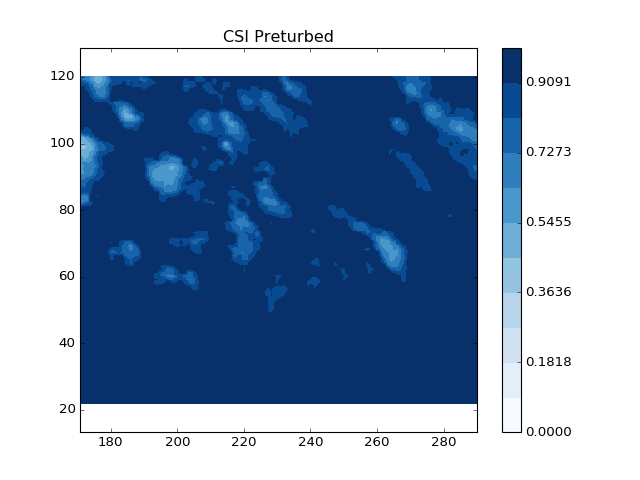

In [193]:
vmin = 0
vmax = 1
# vmin = None
# vmax = None
# vmin = 0
# vmax = 1.65
# cmap = 'Set1'
cmap = 'Blues'

vmin = 0
vmax = 1
nc = 12
bounds = np.linspace(vmin, vmax, nc)
norm = colors.BoundaryNorm(boundaries=bounds, ncolors=256)

plt.figure()
im = plt.pcolormesh(
    x_crop.reshape(crop_shape),
    y_crop.reshape(crop_shape),
    clouds,
    cmap=cmap,
    norm=norm)
plt.colorbar(im)
plt.title('Original')
plt.axis('equal')
plt.gca().set_xlim((plt_x_min, plt_x_max))
plt.gca().set_ylim((plt_y_min, plt_y_max))

plt.figure()
im = plt.pcolormesh(
    x_crop.reshape(crop_shape),
    y_crop.reshape(crop_shape),
    cloud_sample.mean(axis=2),
    cmap=cmap,
    norm=norm)
plt.colorbar(im)
plt.title('CSI mean')
plt.axis('equal')
plt.gca().set_xlim((plt_x_min, plt_x_max))
plt.gca().set_ylim((plt_y_min, plt_y_max))

for n in range(5):
    plt.figure()
    im = plt.pcolormesh(
        x_crop.reshape(crop_shape),
        y_crop.reshape(crop_shape),
        cloud_sample[:, :, n],
        cmap=cmap,
        norm=norm)
    plt.colorbar(im)
    plt.title('CSI Preturbed')
    plt.axis('equal')
    plt.gca().set_xlim((plt_x_min, plt_x_max))
    plt.gca().set_ylim((plt_y_min, plt_y_max))

In [ ]:
sample_mean = cloud_sample.mean(axis=-1)
sample_sd = np.sqrt(cloud_sample.var(axis=-1))

In [ ]:
sn_crop = slice(150, 300)
we_crop = slice(250, 400)
sn_crop = None
we_crop = None

plt_x_min = x_crop.reshape(crop_shape)[sn_crop, we_crop].min()
plt_x_max = x_crop.reshape(crop_shape)[sn_crop, we_crop].max()
plt_y_min = y_crop.reshape(crop_shape)[sn_crop, we_crop].min()
plt_y_max = y_crop.reshape(crop_shape)[sn_crop, we_crop].max()

c_vmin=0
c_vmax=1

plt.figure()
im = plt.pcolormesh(
    x_crop.reshape(crop_shape),
    y_crop.reshape(crop_shape),
    clouds,
    cmap='Blues', vmin=c_vmin, vmax=c_vmax)
plt.colorbar(im)
plt.title('Clouds')
plt.axis('equal')
plt.gca().set_xlim((plt_x_min, plt_x_max))
plt.gca().set_ylim((plt_y_min, plt_y_max))

plt.figure()
im = plt.pcolormesh(
    x_crop.reshape(crop_shape),
    y_crop.reshape(crop_shape),
    sample_mean,
    cmap='Blues', vmin=c_vmin, vmax=c_vmax)
plt.colorbar(im)
plt.title('Sample Mean')
plt.axis('equal')
plt.gca().set_xlim((plt_x_min, plt_x_max))
plt.gca().set_ylim((plt_y_min, plt_y_max))

plt.figure()
im = plt.pcolormesh(
    x_crop.reshape(crop_shape),
    y_crop.reshape(crop_shape),
    cloud_sample[:, :, 0],
    cmap='Blues', vmin=c_vmin, vmax=c_vmax)
plt.colorbar(im)
plt.title('First Sample')
plt.axis('equal')
plt.gca().set_xlim((plt_x_min, plt_x_max))
plt.gca().set_ylim((plt_y_min, plt_y_max))

plt.figure()
im = plt.pcolormesh(
    x_crop.reshape(crop_shape),
    y_crop.reshape(crop_shape),
    sample_mean - clouds,
    cmap='Blues')
plt.colorbar(im)
plt.title('Sample mean - clouds')
plt.axis('equal')
plt.gca().set_xlim((plt_x_min, plt_x_max))
plt.gca().set_ylim((plt_y_min, plt_y_max))

plt.figure()
im = plt.pcolormesh(
    x_crop.reshape(crop_shape),
    y_crop.reshape(crop_shape),
    sample_sd,
    cmap='Blues')
plt.colorbar(im)
plt.title('Standard Deviation')
plt.axis('equal')
plt.gca().set_xlim((plt_x_min, plt_x_max))
plt.gca().set_ylim((plt_y_min, plt_y_max))